In [23]:

import numpy as np

import torch
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models

from tqdm import tqdm
!pip install torchmetrics
import torchmetrics
from torchvision.ops import batched_nms

from torch.optim import Adam
from tqdm.notebook import tqdm
from IPython.display import clear_output
from PIL import Image
import numpy as np
import os

In [24]:
# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

In [25]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


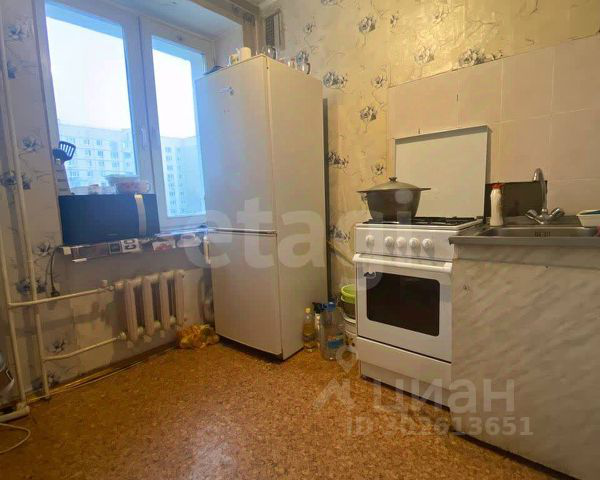

In [26]:
%load_ext autoreload
%autoreload 2
from coco_dataset import CocoDataset

dataset = CocoDataset('datasets\project-2-at-2024-06-26-16-41-863b84de', None, False)

image, target = dataset[691]

image

In [27]:
target

{'boxes': tensor([[317.0370, 298.0741, 352.0000, 363.8518],
         [299.8518, 302.2222, 320.0000, 356.7408]]),
 'labels': tensor([1, 1])}

In [28]:
dataset.target_names()

[{'id': 0, 'name': 'bag'},
 {'id': 1, 'name': 'bottle'},
 {'id': 2, 'name': 'wall-crack'}]

In [29]:
target_names = dataset.target_names()

targetToIdx = { v['name']: v['id'] for v in target_names }
idxToTarget = { v['id']: v['name'] for v in target_names }

In [30]:
targetToIdx

{'bag': 0, 'bottle': 1, 'wall-crack': 2}

In [31]:
idxToTarget

{0: 'bag', 1: 'bottle', 2: 'wall-crack'}

In [32]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
import matplotlib.pyplot as plt

def show(imgs):
    to_pil = T.ToPILImage()

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))

In [33]:
image, target = dataset[692]

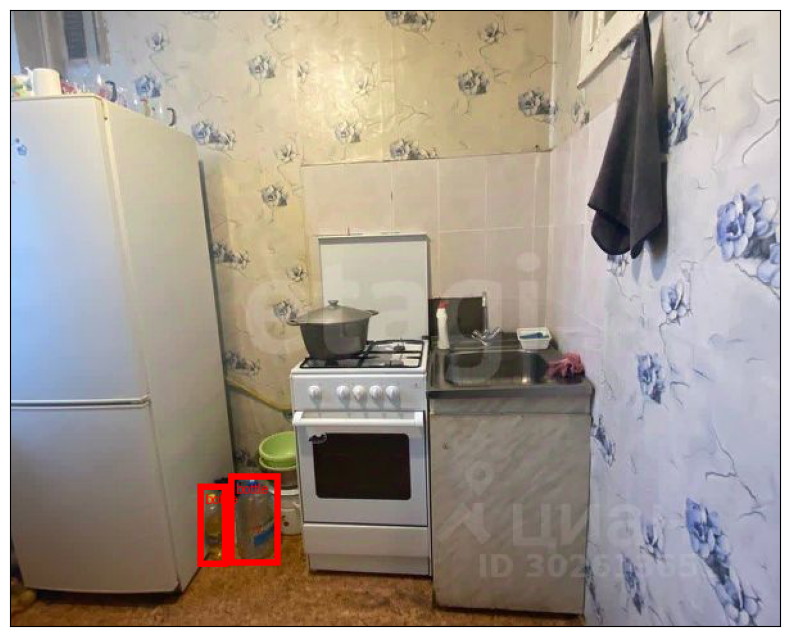

In [34]:
image, target = dataset[692]
draw_boxes_single_image(
    T.PILToTensor()(image),
    target['boxes'],
    [idxToTarget[label.item()] for label in target['labels']]
)

In [35]:
def split_data(dataset, val_size=0.2, seed=42):
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)

    return train_data, test_data

def collate_fn(batch):
    return tuple(zip(*batch))

def create_dataloaders(
    data_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    dataset = CocoDataset(data_dir, transform)
    
    train_set, test_set = split_data(dataset)

    class_names = dataset.target_names

    train_dataloader = DataLoader(
        train_set,                # dataset from which to load the data
        batch_size=batch_size,    # how many samples per batch to load
        shuffle=True,             # set to True to have the data reshuffled at every epoch
        num_workers=num_workers,  # how many subprocesses to use for data loading
        pin_memory=True,          # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
        collate_fn=collate_fn
    )
    test_dataloader = DataLoader(
        test_set,                 # dataset from which to load the data
        batch_size=batch_size,    # how many samples per batch to load
        shuffle=False,            # set to True to have the data reshuffled at every epoch
        num_workers=num_workers,  # how many subprocesses to use for data loading
        pin_memory=True,          # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
        collate_fn=collate_fn
    )

    return train_dataloader, test_dataloader, class_names

In [36]:
# manual_transforms = transforms.Compose([
#     T.ToTensor() 
# ])

In [37]:
train_loader, test_loader, class_names = create_dataloaders(
        data_dir='datasets\project-2-at-2024-06-26-16-41-863b84de',
        transform=T.ToTensor(),
        batch_size=32
    )

In [38]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model():
    model = fasterrcnn_mobilenet_v3_large_320_fpn()

    model.roi_heads.box_predictor = FastRCNNPredictor(1024, len(target_names))

    return model

In [39]:
def train(model):
    model.train()
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    
    for x, y in tqdm(train_loader, desc='Train'):
        x = list(_.to(device).float() for _ in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        optimizer.zero_grad()
        
        output = model(x, y)
        
        loss_sum = sum(loss for loss in output.values())
        
        loss_sum.backward()
        
        optimizer.step()

In [40]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    keep = batched_nms(orig_prediction['boxes'], orig_prediction['scores'], orig_prediction['labels'], iou_thresh)

    final_prediction = orig_prediction

    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [41]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    to_pil = T.ToPILImage()
    to_tensor = T.PILToTensor()

    xs, ys = batch

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v.to(device) for k, v in model([x.to(device)])[0].items()}

        prediction = apply_nms(prediction)

        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idxToTarget[label.item()] for label in y['labels']], width=5, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idxToTarget[label.item()] for label in prediction['labels']], width=5, colors='red')

        fig, ax = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [42]:
def whole_train_valid_cycle(model, num_epochs, title):
    batch = next(iter(test_loader))

    for epoch in range(num_epochs):
        train(model)

        clear_output()

        visualize(model, batch)

In [43]:
model = get_detection_model().to(device)

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

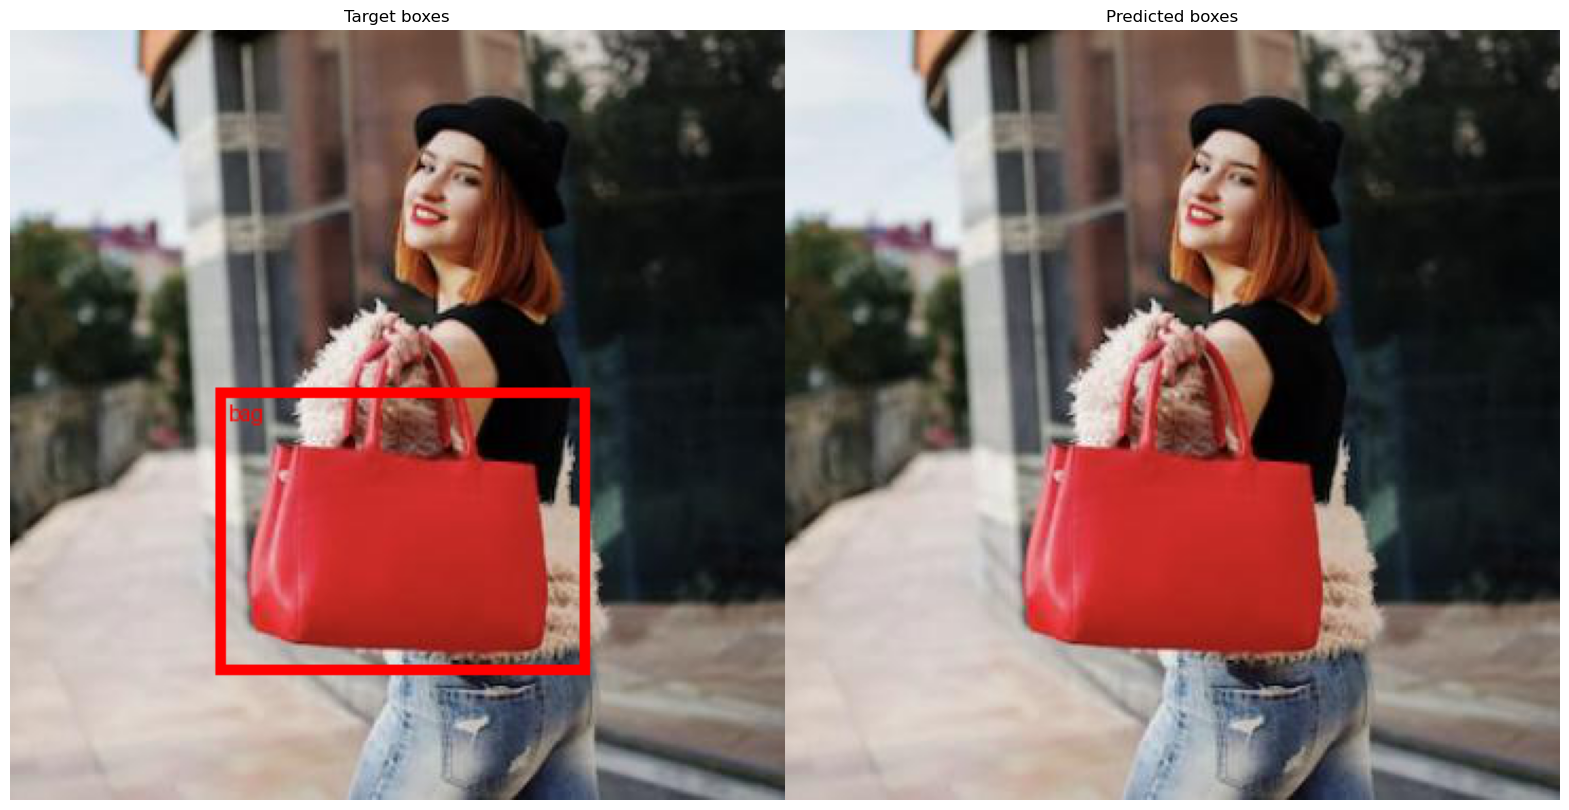

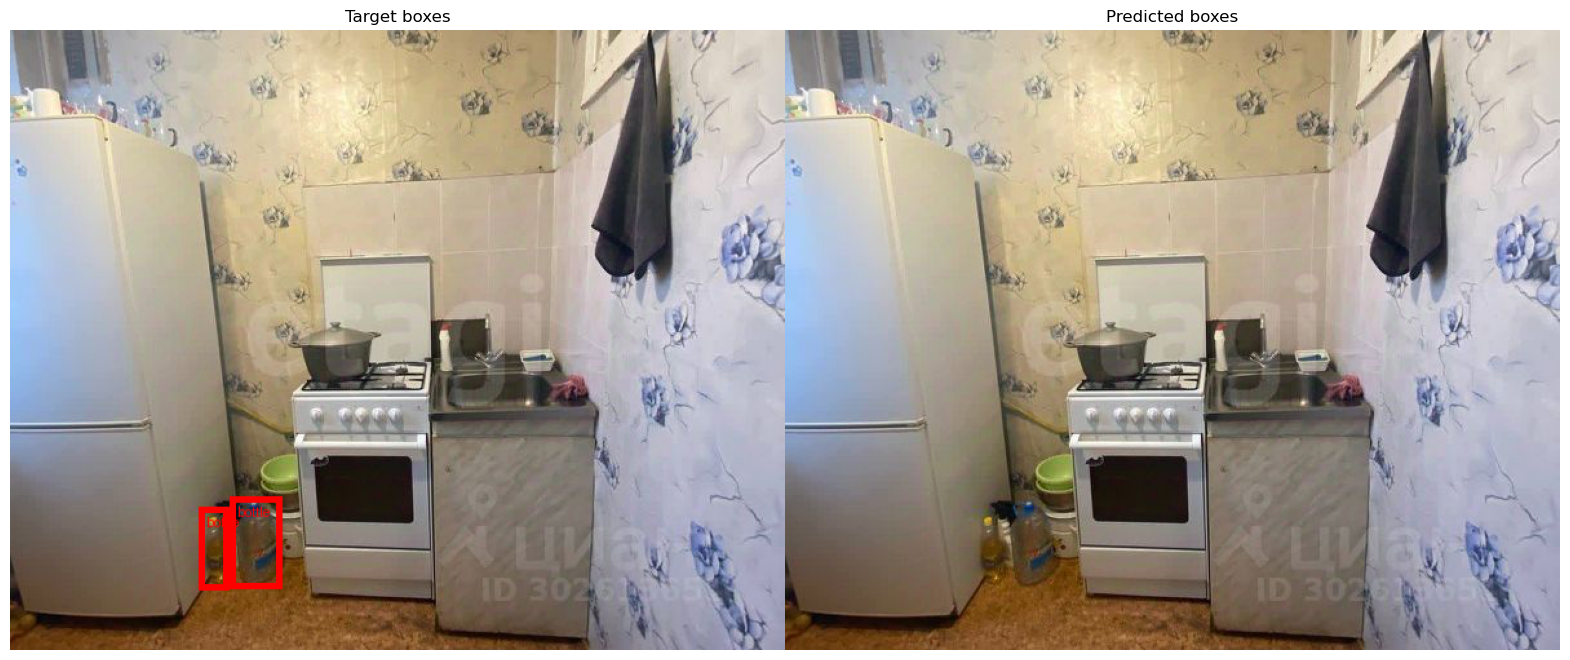

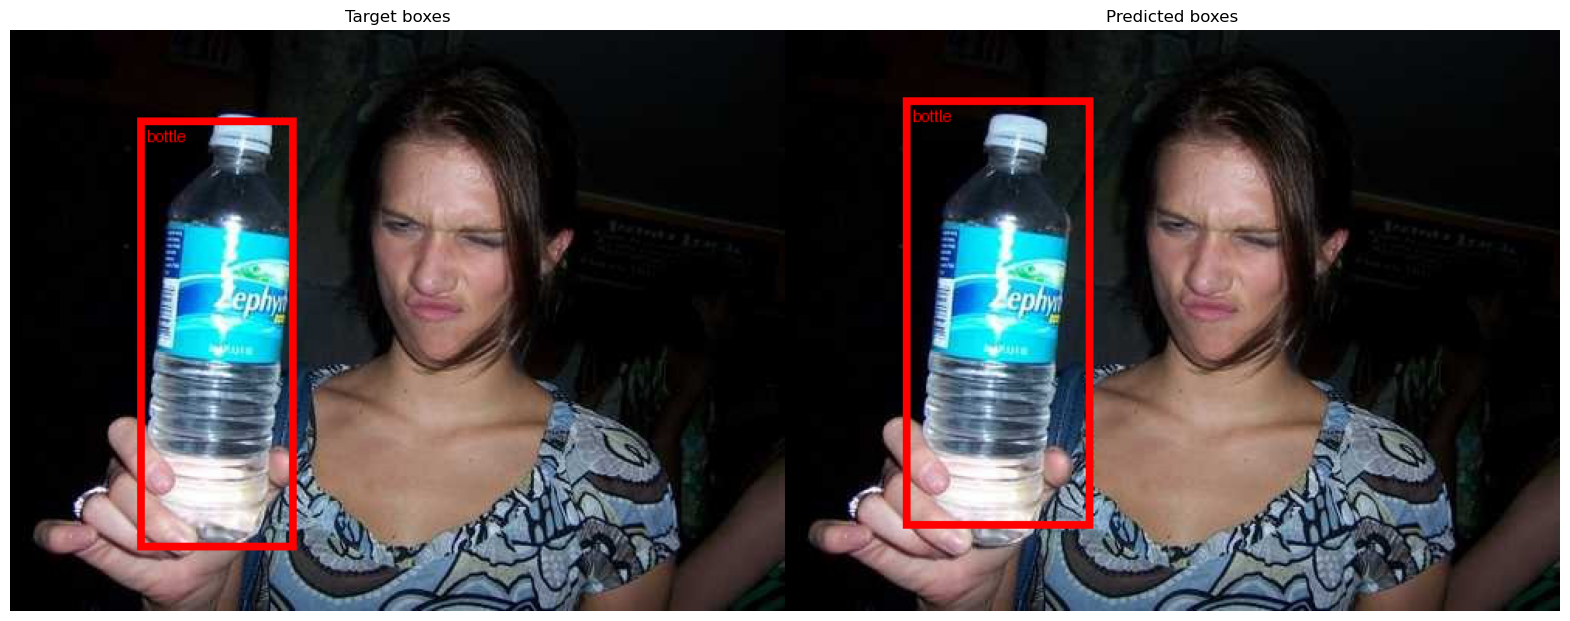

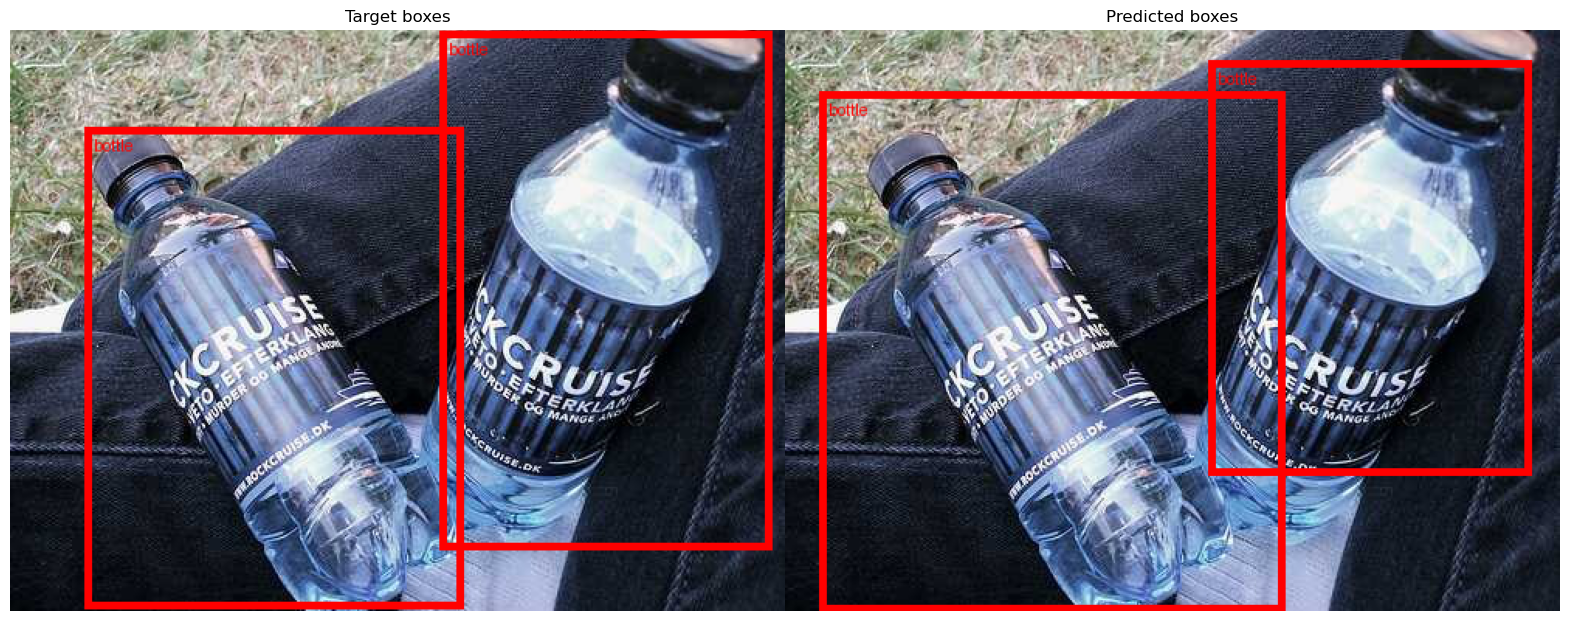

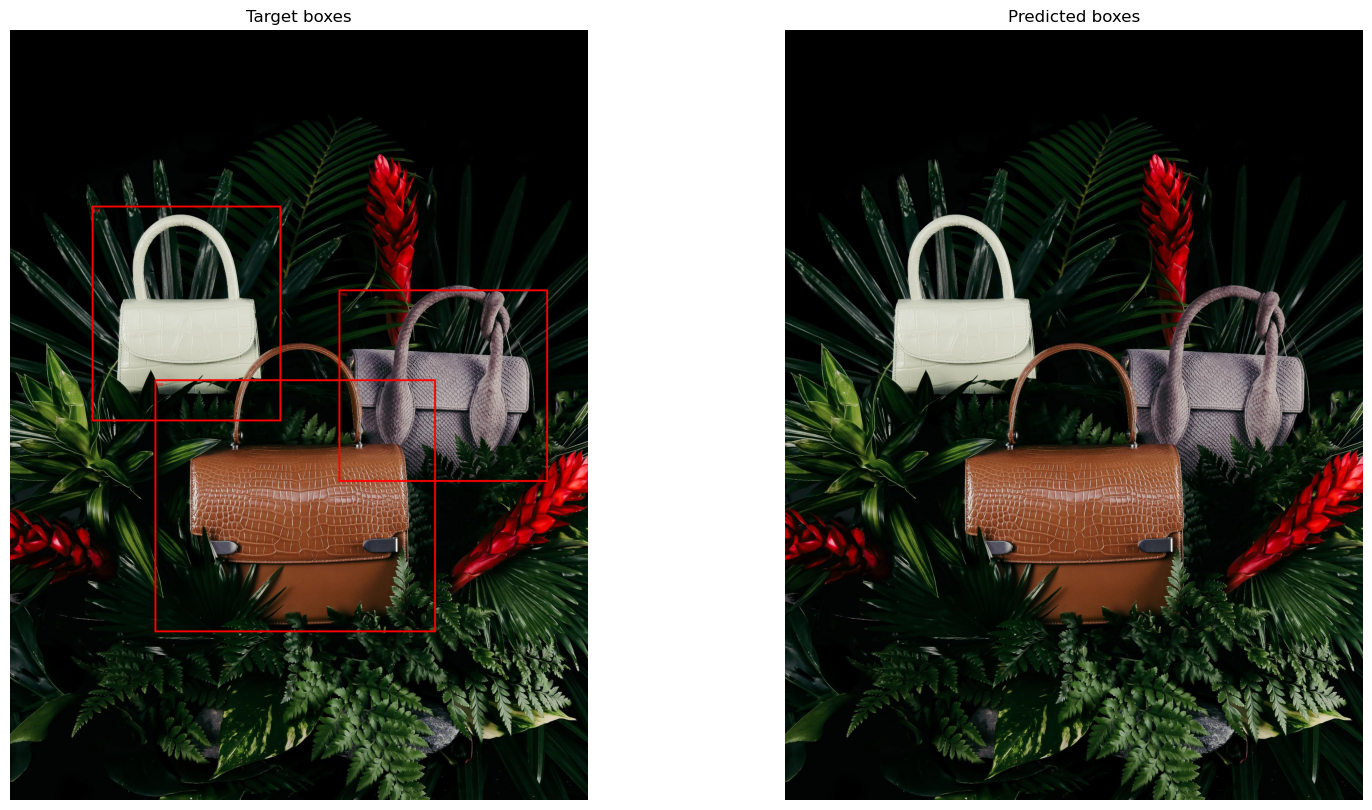

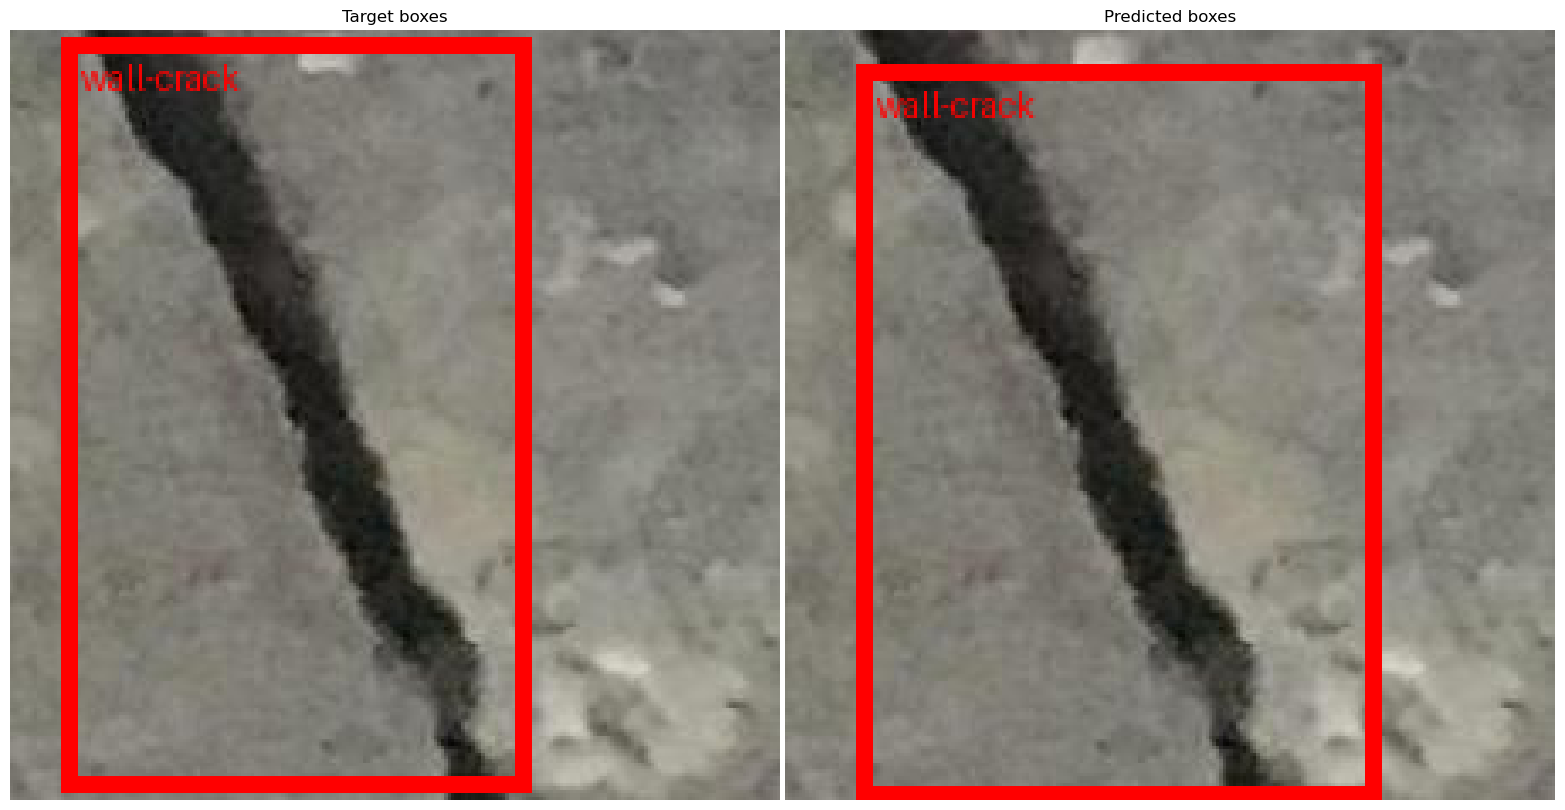

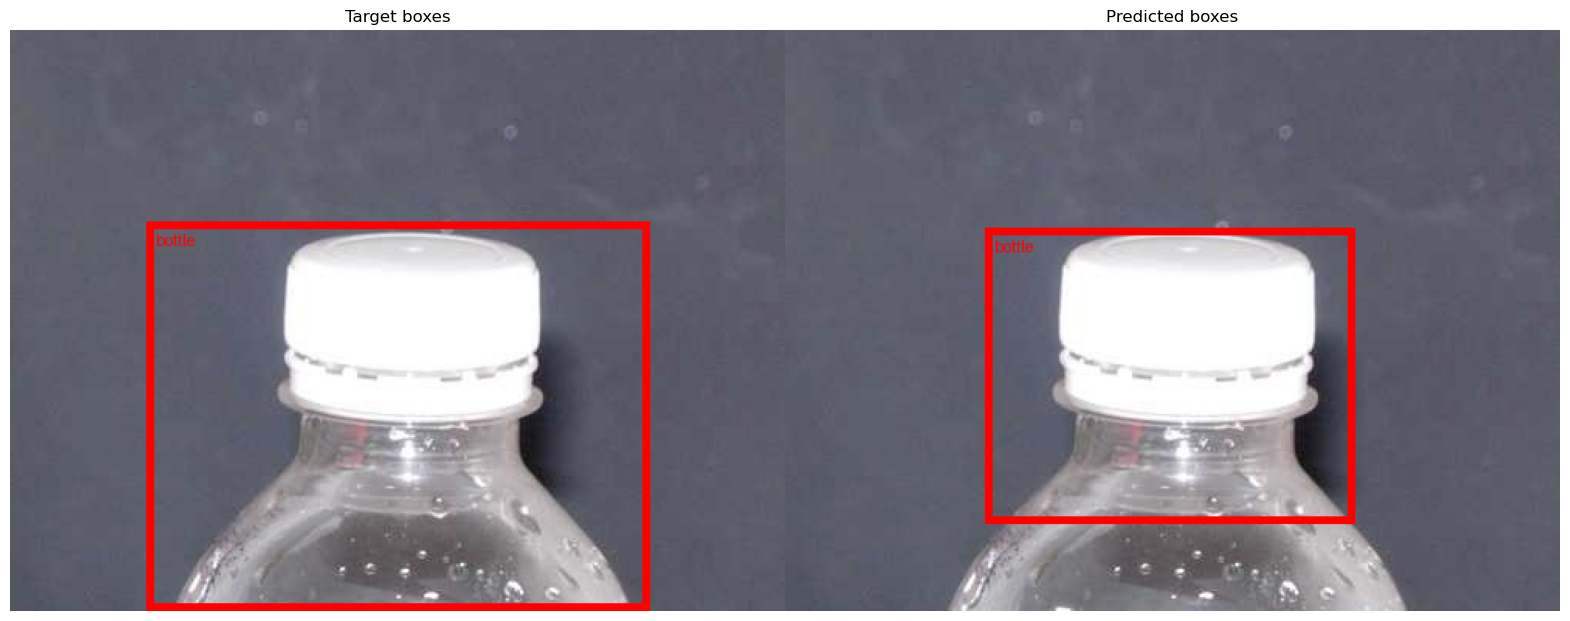

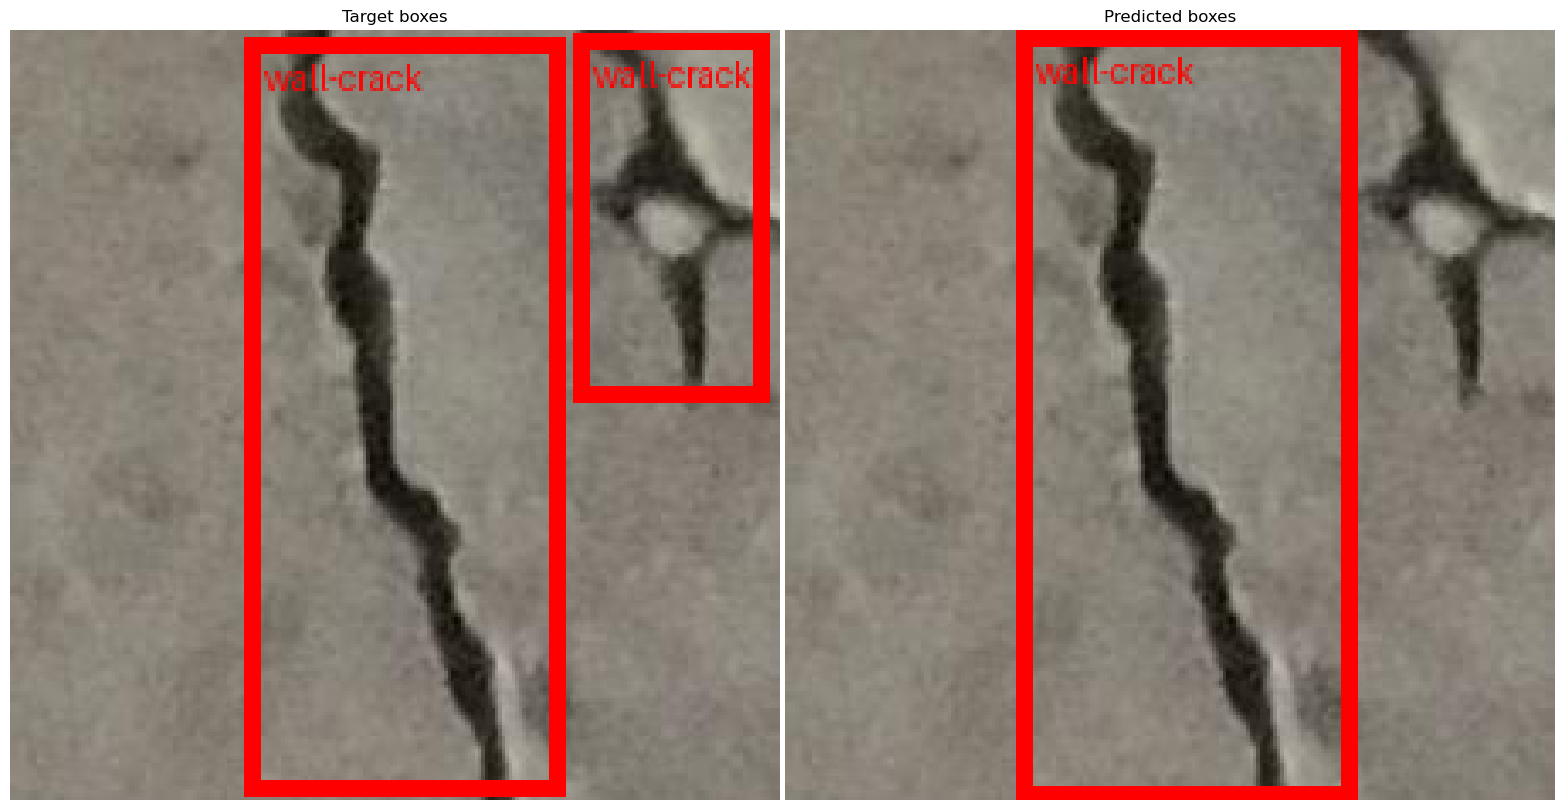

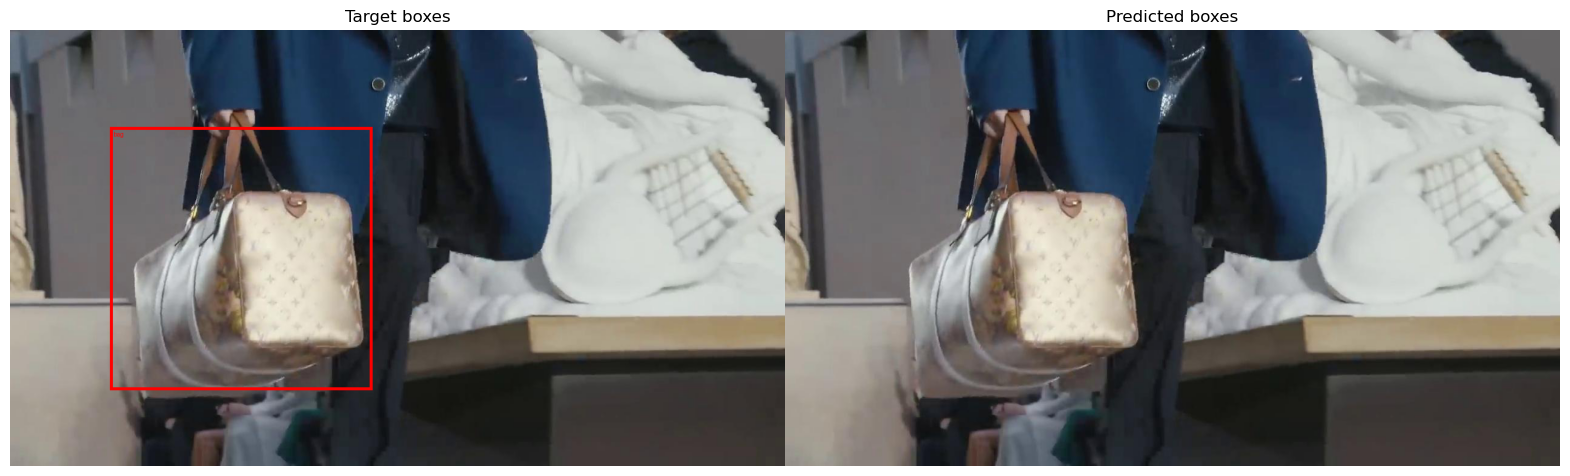

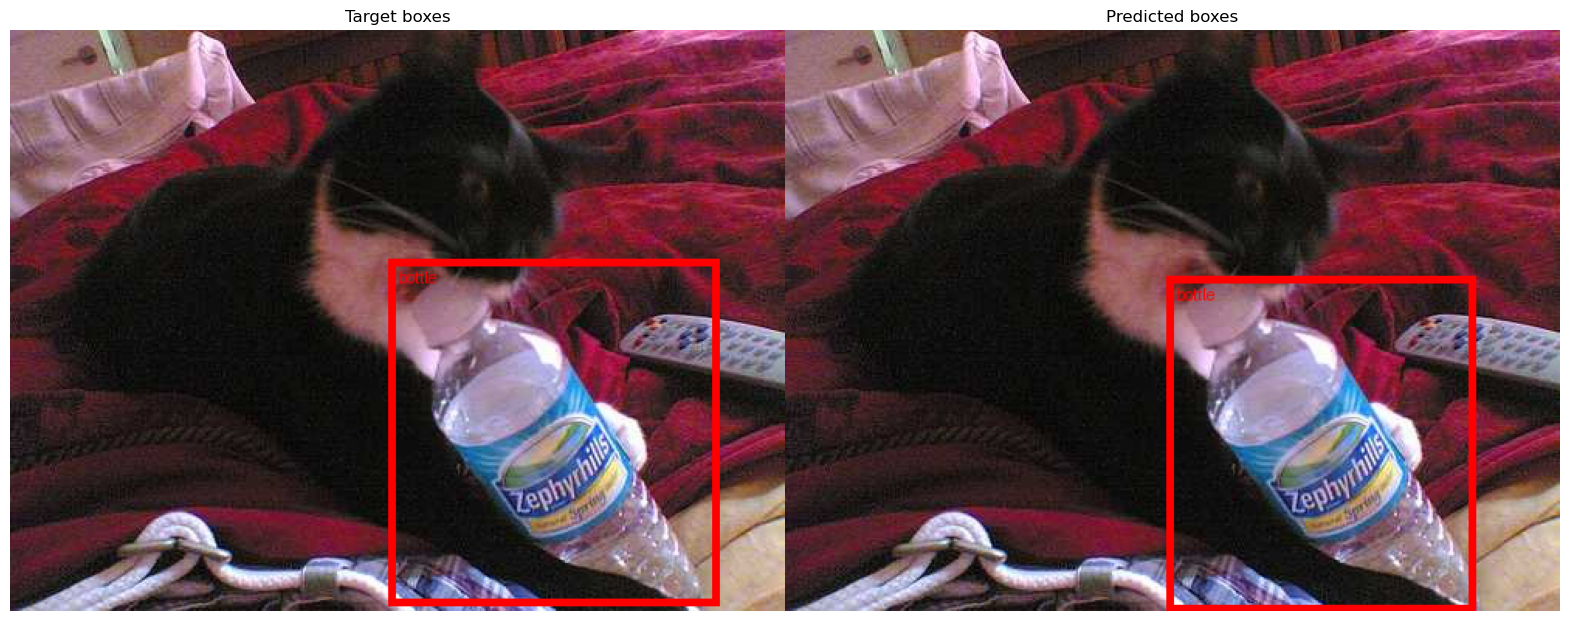

In [44]:
whole_train_valid_cycle(model, 15, 'Faster R-CNN finetune')